In [1]:
import random
import math

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn import tree
import joblib

import scipy

In [4]:
plt.rcParams["figure.figsize"] = (15, 17)

In [5]:
def convertFahrenheitToCelsius(f):
    return (f - 32) / 1.8

## load random forest model

In [6]:
filename_min = './min_random_forest_model.sav'
filename_max = './max_random_forest_model.sav'

In [7]:
rfr_min = joblib.load(filename_min)
rfr_max = joblib.load(filename_max)

## create test data from test dataset

In [8]:
pth_min = '../processed_data/test_min.csv'
df_min = pd.read_csv(pth_min)

In [9]:
pth_max = '../processed_data/test_max.csv'
df_max = pd.read_csv(pth_max)

In [10]:
df_min.shape

(57, 14)

In [11]:
df_max.shape

(9, 14)

In [12]:
df_combine = pd.concat([df_min, df_max])

In [13]:
df_combine

,Unnamed: 0,height,weight,gender,bmi,age,rh,heart_rate,stress_level,skin_temp,eda,Clo,Act,env_temp
0,166,1.77,68.0,-1.0,21.705129,24.0,57.779,76.298872,23.987342,31.672874,0.877379,0.54,1.0,25.841111
1,25,1.83,74.0,-1.0,22.096808,24.0,46.650,84.000000,23.987342,31.693000,0.009496,0.50,1.1,26.390000
2,229,1.63,50.0,1.0,18.818924,23.0,41.050,86.000000,23.987342,30.563000,0.281910,0.50,1.0,24.641111
3,217,1.63,50.0,1.0,18.818924,23.0,39.170,67.000000,7.000000,31.672874,0.059989,0.50,1.0,23.868889
4,10,1.63,50.0,1.0,18.818924,23.0,54.550,79.000000,27.000000,31.672874,0.017312,0.50,1.0,24.737778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,43,1.77,58.0,-1.0,18.513199,23.0,51.234,102.500000,78.000000,33.636000,0.585949,0.36,1.3,26.817778
5,26,1.60,52.5,1.0,20.507812,24.0,51.538,88.158537,62.485294,32.559814,-0.100261,0.53,1.0,22.608889
6,6,1.77,58.0,-1.0,18.513199,23.0,55.272,87.000000,62.485294,32.915000,0.006857,0.36,1.0,26.377778
7,8,1.77,90.0,-1.0,28.727377,28.0,60.389,67.000000,62.485294,31.013000,0.188456,0.36,1.1,26.377778


In [14]:
X_columns = ['height', 'weight', 'gender', 'bmi', 'age', 'rh', \
              'heart_rate', 'stress_level', 'skin_temp', 'eda', \
              'Clo', 'Act']

In [15]:
X = df_combine[X_columns]
y = df_combine['env_temp']

## predict

### predict comfort zone min value

In [16]:
y_pred_min = rfr_min.predict(X)

### transfer to Celsius

In [17]:
y_pred_min

array([25.44036941, 25.46763214, 24.41454745, 24.30847003, 25.18832407,
       24.26348032, 25.06051215, 23.8025706 , 24.46558912, 25.0050625 ,
       24.68368403, 24.74662153, 24.02696296, 24.32523958, 24.83440509,
       24.6941794 , 23.912     , 24.0347446 , 24.37434028, 24.02503472,
       23.5637662 , 25.16809259, 23.908625  , 23.66677431, 25.2109294 ,
       24.02904061, 24.01406366, 24.87760185, 22.98154398, 25.06806481,
       24.36365972, 25.33479398, 24.61299421, 24.09762616, 24.90424306,
       23.83358449, 24.81524672, 24.02012731, 24.12263079, 24.67009568,
       23.13755093, 24.13900231, 24.3212662 , 24.26652431, 22.67534954,
       24.53751244, 24.12100231, 24.27957639, 24.68502662, 25.36268461,
       23.6534537 , 24.85530208, 24.72193576, 23.67936343, 24.01928067,
       24.12596209, 24.79369552, 25.7304375 , 25.85613773, 25.4255787 ,
       23.99324074, 25.27455208, 24.31933333, 24.85499421, 24.09095949,
       25.33662809])

### predict comfort zone max value

In [18]:
y_pred_max = rfr_max.predict(X)

### transfer to Celsius

In [19]:
y_pred_max

array([26.99285764, 28.24967907, 25.7692629 , 25.95623165, 25.14688988,
       27.54073115, 25.28378671, 25.9176746 , 26.68895784, 26.20649256,
       26.58774157, 26.00869544, 27.23472173, 25.77650496, 27.36237897,
       26.58066171, 26.9429752 , 26.15909425, 27.32281399, 27.45898661,
       25.52466518, 27.25844395, 25.89204018, 26.03027381, 26.48997222,
       25.91708234, 27.4620119 , 26.47147123, 25.99730853, 25.1853006 ,
       27.3624127 , 25.3646622 , 26.6783006 , 25.75238492, 25.62940923,
       25.71869643, 26.64890873, 25.75697024, 26.04920139, 26.69131399,
       26.05006349, 26.05044048, 27.1315129 , 25.58225   , 25.78458333,
       25.98442659, 27.57749653, 26.60359226, 26.69166468, 27.17638194,
       27.55314335, 25.38143651, 26.86357639, 26.93907143, 25.67230208,
       25.68319643, 26.40880556, 26.50987897, 27.06311657, 26.22809077,
       27.11436954, 26.8311131 , 24.91902381, 26.35058681, 26.97459276,
       26.28780556])

### detect error

In [20]:
errorIdx = []
for i in range(len(y_pred_min)):
    if y_pred_max[i] <= y_pred_min[i]:
        errorIdx.append(i)

In [21]:
errorIdx

[4]

In [22]:
df_combine.iloc[errorIdx,:]

,Unnamed: 0,height,weight,gender,bmi,age,rh,heart_rate,stress_level,skin_temp,eda,Clo,Act,env_temp
4,10,1.63,50.0,1.0,18.818924,23.0,54.55,79.0,27.0,31.672874,0.017312,0.5,1.0,24.737778


### delete the unacceptable values

In [23]:
t_min = []
t_max = []
for i in range(len(y_pred_min)):
    if y_pred_min[i] <= y_pred_max[i]:
        t_min.append(y_pred_min[i])
        t_max.append(y_pred_max[i])
    else:
        t_min.append(y_pred_min[i])
        t_max.append(y_pred_min[i])

In [24]:
len(t_min)

66

### plot zone

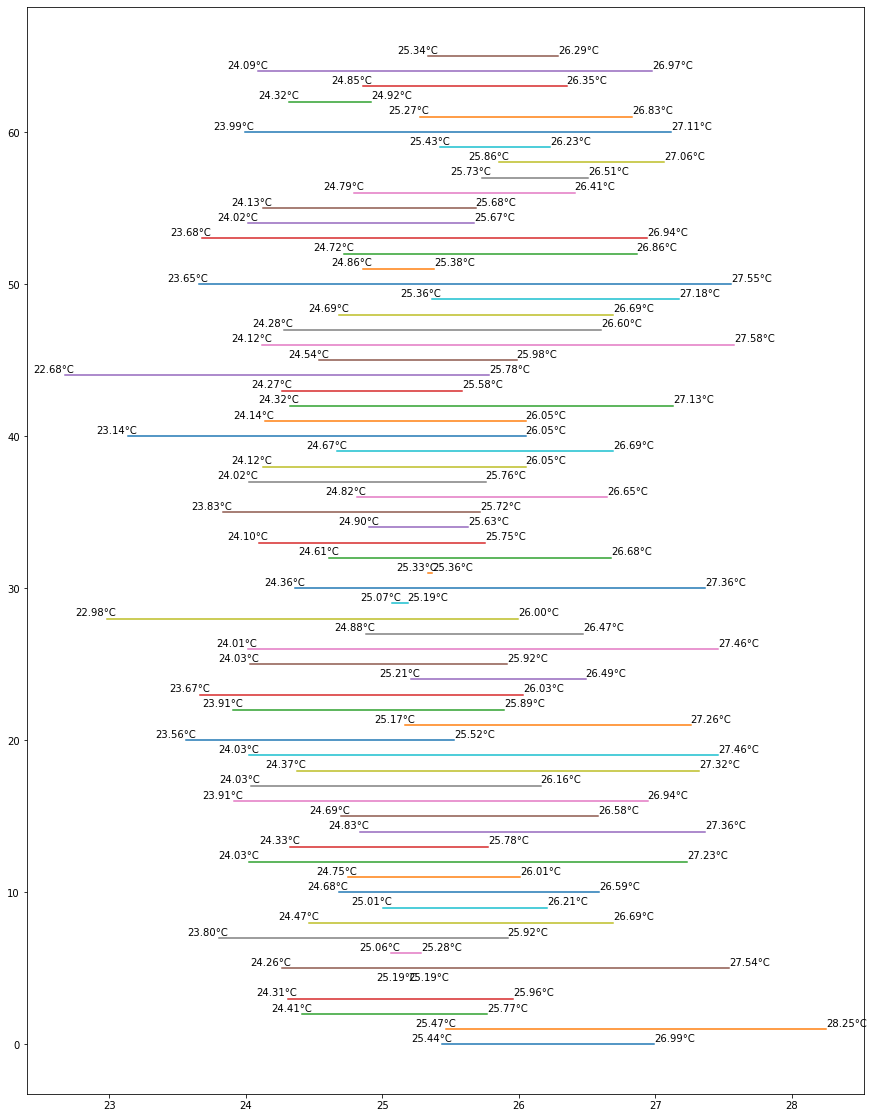

In [25]:
plt.rcParams["figure.figsize"] = (15, 20)
# draw comfort zone
for i in range(len(t_min)):
    plt.plot([t_min[i], t_max[i]],[i, i])
    
# tag comfort zone min $ max
for i in range(len(t_min)):
    plt.text(t_min[i]- 0.23, i+0.2, "%.2f°C" % t_min[i])
    plt.text(t_max[i], i+0.2, "%.2f°C" % t_max[i])

plt.show()

## predict group tempreture model

In [26]:
import math

class OptimalGroupTempreture():
    def __init__(self, minTs, maxTs, sensitivity=1.0, defaultMinMaxRange=1.0):
        """
        sensitivity > 0, less means more sensitive
        defaultMinMaxRange > 0 or == None
        """
        if len(minTs) != len(maxTs):
            print('Length of min tempreture records and max tempretur records are not equal!')
            return None
        self.minTs = minTs
        self.maxTs = maxTs
        self.sensitivity = sensitivity
        self.defaultMinMaxRange = defaultMinMaxRange
        self.otdDF = None
        self.optimalTargetTemperatureOTD = None
        self.max_otd = None
        self.min_otd = None
    
    def getTempreture(self, model='auto', sensitivePeoplePercentageLimit=0.1, sensitiveRange=2, ppd=0.1):
        """
        model = 'auto', 'sensitive first', 'otd model'
        sensitivePeoplePercentage is > 0 and < 1
        sensitiveRange is > 0, unit is Fahrenheit Degree
        ppd: only for OTD model
        """
        minTs = self.minTs
        maxTs = self.maxTs

        if self.defaultMinMaxRange is not None:
            avgTs = [(maxTs[i] + minTs[i]) / 2 for i in range(len(minTs))]
            tRanges = [maxTs[i] - minTs[i] for i in range(len(minTs))]
            checkedtRanges = []
            for i in range(len(tRanges)):
                t = tRanges[i] if tRanges[i] > 0 else self.defaultMinMaxRange
                checkedtRanges.append(t)
        else:
            avgTs = []
            tRanges = [maxTs[i] - minTs[i] for i in range(len(minTs))]
            checkedtRanges = []
            for i in range(len(tRanges)):
                if tRanges[i] > 0:
                    t = tRanges[i]
                    checkedtRanges.append(t)
                    avgTs.append((maxTs[i] + minTs[i]) / 2)

        # model selection
        if model == 'sensitive first':
            print('sensitive first model')
            targetTempreture = self.sensitiveFirst(checkedtRanges, avgTs)
        elif model == 'otd model':
            print('otd model')
            targetTempreture = self.otdModel(checkedtRanges, avgTs, ppd)
        elif model == 'auto':
            lengthOfSensitivePeople = len([tRange for tRange in checkedtRanges if tRange <= sensitiveRange])
            if lengthOfSensitivePeople / len(checkedtRanges) >= sensitivePeoplePercentageLimit:
                print('sensitive first model')
                print('sensitive people percentage:', lengthOfSensitivePeople / len(checkedtRanges))
                targetTempreture = self.sensitiveFirst(checkedtRanges, avgTs)
            else:
                print('otd model')
                targetTempreture = self.otdModel(checkedtRanges, avgTs, ppd)
                if targetTempreture is None:
                    print('otd model does not find a acceptable value, use sensitive first model')
                    targetTempreture = self.sensitiveFirst(checkedtRanges, avgTs)
        else:
            print('Wrong model')
            return None

        return targetTempreture

    def sensitiveFirst(self, checkedtRanges, averageTs):
        weights = [self.computeWeight(tRange) for tRange in checkedtRanges]
        weightedTs = [averageTs[i] * weights[i] for i in range(len(averageTs))]
        targetTempreture = sum(weightedTs) / sum(weights)
        return targetTempreture

    def computeWeight(self, tRange):
        return (1 / tRange) ** self.sensitivity

    def otdModel(self, checkedtRanges, averageTs, ppd):
        forFig = []
        numberOfPeople = len(checkedtRanges)
        permitNumberOfUncomfortablePeople = math.floor(numberOfPeople * ppd)
        otdMax = (numberOfPeople - permitNumberOfUncomfortablePeople) * 1 + \
            permitNumberOfUncomfortablePeople * (numberOfPeople + 1)

        rangeTs = [self.otdDecideComfortness(checkedtRanges[i], averageTs[i]) for i in range(len(checkedtRanges))]

        # find minT and maxT
        minT = min([averageTs[i] - checkedtRanges[i] / 2 for i in range(len(checkedtRanges))])
        maxT = max([averageTs[i] + checkedtRanges[i] / 2 for i in range(len(checkedtRanges))])

        acceptableTs = []
        max_otd = float('-inf')
        min_otd = float('inf')
        for t10 in range(int(minT * 10), int(maxT * 10) + 1):
            t = t10 / 10
            otd = self.computeOTD(t, numberOfPeople, rangeTs)
            
            forFig.append([t, otd, 1])
            max_otd = max(max_otd, otd)
            min_otd = min(min_otd, otd)
            if otd <= otdMax:
                acceptableTs.append([t, otd])
        
        self.max_otd = max_otd
        self.min_otd = min_otd
        
        if acceptableTs == []:
            return None
        acceptableTs.sort(key=lambda x: x[1])
        maxValues = [acceptableTs[0][0]]
        for i in range(1, len(acceptableTs)):
            if acceptableTs[i][1] == acceptableTs[0][1]:
                maxValues.append(acceptableTs[i][0])
#         print(acceptableTs)
        opt_temp = sum(maxValues) / len(maxValues)
        forFig.append([opt_temp, self.computeOTD(opt_temp, numberOfPeople, rangeTs), 20])
        self.otdDF = pd.DataFrame(forFig, columns=['temperature(°C)', 'otd', 'isFinal'])
        
        self.optimalTargetTemperatureOTD = opt_temp
        return opt_temp
    
    def computeOTD(self, t, numberOfPeople, rangeTs):
        otd = 0
        for x in rangeTs:
            if t >= x[0][0] and t <= x[0][1]:
                otd += 0
            elif t >= x[1][0] and t <= x[1][1]:
                otd += 1
            elif t >= x[2][0] and t <= x[2][1]:
                otd += numberOfPeople + 1
            else:
                otd += (numberOfPeople + 1) * 2
        return otd

                
    def otdDecideComfortness(self, checkedtRange, averageT, \
                            littleUncomfortable=[1 , 1.4], \
                            uncomfortable=[1.4, 1.7]):
        radius = checkedtRange / 2
        rangeComfortable = [averageT - radius * littleUncomfortable[0], averageT + radius * littleUncomfortable[0]]
        rangeLittleUncomfortable = [averageT - radius * littleUncomfortable[1], averageT + radius * littleUncomfortable[1]]
        rangeUncomfortable = [averageT - radius * uncomfortable[1], averageT + radius * uncomfortable[1]]
        return [rangeComfortable, rangeLittleUncomfortable, rangeUncomfortable]
    
    def drawOtdValue(self):
        ct = sns.color_palette()
        ct = [ct[2], ct[3]]
        sns.set_theme(style="darkgrid")
        sns.relplot(x="temperature(°C)", y="otd", data=self.otdDF, hue="isFinal", palette=ct, \
                    size="isFinal", height=7, aspect=16/9)

In [27]:
ogt = OptimalGroupTempreture(y_pred_min, y_pred_max, defaultMinMaxRange=None)

In [28]:
# use sensitive first model to predict the group comfortable tempreture
ogt.getTempreture(sensitiveRange=4)

sensitive first model
sensitive people percentage: 1.0


25.351930145786874

In [32]:
# use otd model to predict the group comfortable tempreture
ogt.getTempreture(model='otd model', ppd=0.5)

otd model


25.2

In [33]:
ogt.otdDF

,temperature(°C),otd,isFinal
0,22.6,8055,1
1,22.7,8054,1
2,22.8,8054,1
3,22.9,7659,1
4,23.0,7460,1
5,23.1,7263,1
6,23.2,7000,1
7,23.3,6868,1
8,23.4,6214,1
9,23.5,5754,1


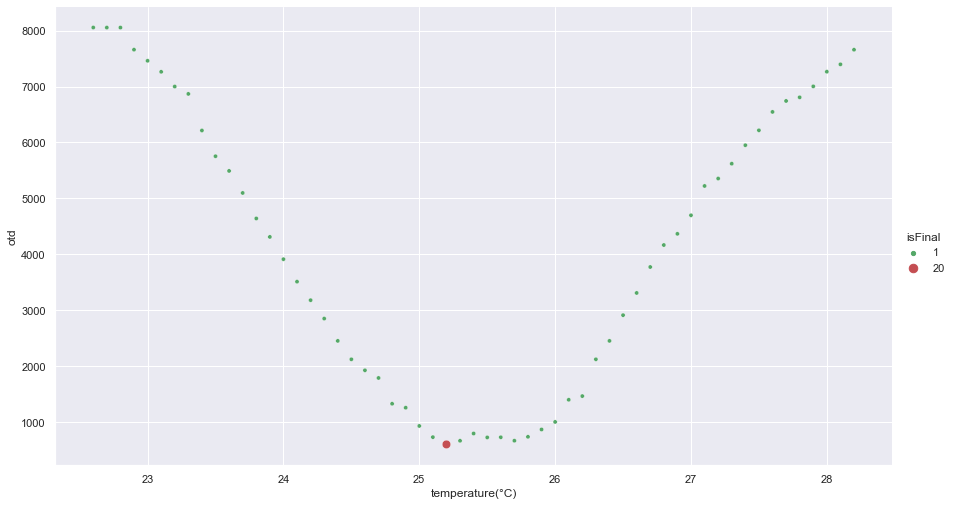

In [34]:
ogt.drawOtdValue()

## exmine with other model

### examine max prediction

In [ ]:
y_pred_pmv = np.array(df_max['pmv_temp_max'])

In [ ]:
y_pred_pmv

In [ ]:
X = df_max[X_columns]
y_true = np.array(df_max['env_temp'])

In [ ]:
y_true

In [ ]:
y_pred_rf = rfr_max.predict(X)

In [ ]:
y_pred_rf

#### max - mse

In [ ]:
# mean squared error
mse_rf = mean_squared_error(y_true, y_pred_rf)
mse_pmv = mean_squared_error(y_true, y_pred_pmv)
display(mse_rf)
display(mse_pmv)

In [ ]:
# drop ratio
(mse_pmv - mse_rf) / mse_pmv

#### max - r2

In [ ]:
# R2 score
r2_rf = r2_score(y_true, y_pred_rf)
r2_pmv = r2_score(y_true, y_pred_pmv)
display(r2_rf)
display(r2_pmv)

### examine min prediction

In [ ]:
y_pred_pmv = np.array(df_min['pmv_temp_min'])

In [ ]:
y_pred_pmv

In [ ]:
X = df_min[X_columns]
y_true = np.array(df_min['env_temp'])

In [ ]:
y_true

In [ ]:
y_pred_rf = rfr_max.predict(X)

In [ ]:
y_pred_rf

#### min - mse

In [ ]:
# mean squared error
mse_rf = mean_squared_error(y_true, y_pred_rf)
mse_pmv = mean_squared_error(y_true, y_pred_pmv)
display(mse_rf)
display(mse_pmv)

In [ ]:
# drop ratio
(mse_pmv - mse_rf) / mse_pmv

#### min - r2

In [ ]:
# R2 score
r2_rf = r2_score(y_true, y_pred_rf)
r2_pmv = r2_score(y_true, y_pred_pmv)
display(r2_rf)
display(r2_pmv)